# Self-Attention from Scratch: Finding the Largest Number in a Sequence

This notebook is a simple implementation of a **self-attention**-based neural network from scratch (the core mechanism behind Transformers) to identify the position of the largest number in a sequence.

**Self-Attention Overview:**  
Self-attention is a mechanism that allows a model to weigh the importance of each element in a sequence relative to others. For each number in the sequence, the model computes **queries, keys, and values** and uses them to calculate attention weights, effectively “deciding” which numbers to focus on when making a prediction.

**Why This Works for Finding the Maximum:**  
The model can learn to assign higher attention to larger numbers because, in each sequence, the goal is to identify the position of the largest value. Through training, the network adjusts its embeddings and attention weights so that the number with the greatest magnitude gets the strongest signal, allowing the final feed-forward layers to correctly predict its position.

Key steps include:
- Selecting a random length for input sequence (`seq_len`) and generating `train_samples` of this length.
- Normalizing input sequences and embedding each number into a dense vector.
- Computing query, key, and value vectors for self-attention.
- Calculating attention weights via the scaled dot-product mechanism.
- Using a feed-forward network to predict the position of the maximum number.
- Training and evaluating the model with randomly generated sequences, and visualizing results using a confusion matrix.

This project provides an intuitive, hands-on introduction to how attention mechanisms allow models to focus on important elements within sequences.

**Note:** _This model has not been optimized for performance; its purpose is to demonstrate how the self-attention mechanism works in a generalizable way and how it can be applied outside of the Transformer context—and even without fine-tuning, we observe good performance on the test data._


In [39]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [40]:
seq_len = np.random.randint(10,30)
print(f"seq_len: {seq_len}")

seq_len: 13


In [41]:
train_samples = 10000
train_data_input = torch.Tensor([[np.random.randint(1000) for _ in range(seq_len)] for _ in range(train_samples)])

In [42]:
train_data_input

tensor([[956., 520.,  91.,  ..., 705., 470., 795.],
        [802., 601., 798.,  ..., 600., 290., 699.],
        [526., 969., 233.,  ..., 870., 686., 933.],
        ...,
        [ 17., 929., 774.,  ..., 514., 567., 542.],
        [390., 988., 161.,  ..., 535., 234., 642.],
        [338., 867., 285.,  ..., 970., 787., 139.]])

In [43]:
class SelfAttentionMaximizer(nn.Module):
  def __init__(self, embedding_dim, seq_len):
    super().__init__()
    self.input_embed = nn.Linear(1, embedding_dim)
    self.w_q = nn.Linear(embedding_dim, embedding_dim)
    self.w_k = nn.Linear(embedding_dim, embedding_dim)
    self.w_v = nn.Linear(embedding_dim, embedding_dim)
    self.ffn1 = nn.Linear(embedding_dim*seq_len, 32)
    self.ffn2 = nn.ReLU()
    self.output_layer = nn.Linear(32, seq_len)


  def forward(self, x, embedding_dim):
    # normalize inputs
    x = (x - x.min(dim=1, keepdim=True)[0]) / (x.max(dim=1, keepdim=True)[0] - x.min(dim=1, keepdim=True)[0] + 1e-6)

    # convert each number ("token") to a dense embedding vector
    embedded_input = self.input_embed(x.unsqueeze(-1).float())

    # get query, key, value vectors for each token
    q = self.w_q(embedded_input) # shape (batch_size, seq_len, embedding_dim)
    k = self.w_k(embedded_input)
    v = self.w_v(embedded_input)

    # scale and normalize to weight
    raw_attention_weight = torch.matmul(q, k.transpose(-2,-1))
    attention = torch.softmax(raw_attention_weight/embedding_dim**0.5, dim=-1)

    output = torch.matmul(attention, v) # shape (batch_size, seq_len, embedding_dim)

    # Pass through FFN and get prediction
    x = output.view(output.shape[0], -1) # flatten (_,seq_len,embedding_dim)
    x = self.ffn1(x)
    x = self.ffn2(x)

    predicted_position_logits = self.output_layer(x)

    return predicted_position_logits

  def compute_loss(self, y_pred, y_true):
    criterion = nn.CrossEntropyLoss()
    loss = criterion(y_pred, y_true)
    return loss




In [44]:
# TRAINING AND TESTING LOOP

batch_size = 32
num_epochs = 20
embedding_dim = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# train-test split
dataset_size = train_data_input.shape[0]
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
indices = torch.randperm(dataset_size)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = train_data_input[train_indices].to(device)
test_data = train_data_input[test_indices].to(device)

model = SelfAttentionMaximizer(embedding_dim, seq_len).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_predicted_outcome = []

    for batch in range(0, train_data.shape[0], batch_size):
        x_batch = train_data[batch:batch + batch_size]
        y_batch = x_batch.argmax(dim=1).to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch, embedding_dim)
        loss = model.compute_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)
        predicted_positions = y_pred.argmax(dim=1)
        train_correct += (predicted_positions == y_batch).sum().item()
        train_total += y_batch.size(0)

        # Collect predictions
        train_predicted_outcome.append(predicted_positions.detach().cpu().numpy())

    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total * 100
    train_predicted_outcome = np.concatenate(train_predicted_outcome)

    # ---- Testing ----
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    test_predicted_outcome = []
    test_true_outcome = []

    with torch.no_grad():
        for batch in range(0, test_data.shape[0], batch_size):
            x_batch = test_data[batch:batch + batch_size]
            y_batch = x_batch.argmax(dim=1).to(device)

            y_pred = model(x_batch, embedding_dim)
            loss = model.compute_loss(y_pred, y_batch)

            test_loss += loss.item() * x_batch.size(0)
            predicted_positions = y_pred.argmax(dim=1)
            test_correct += (predicted_positions == y_batch).sum().item()
            test_total += y_batch.size(0)

            # Collect predictions
            test_predicted_outcome.append(predicted_positions.detach().cpu().numpy())
            test_true_outcome.append(y_batch.detach().cpu().numpy())


    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total * 100
    test_predicted_outcome = np.concatenate(test_predicted_outcome)
    test_true_outcome = np.concatenate(test_true_outcome)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
        f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%"
    )

Using device: cuda
Epoch 1 | Train Loss: 2.5663, Train Acc: 8.04% | Test Loss: 2.5648, Test Acc: 7.55%
Epoch 2 | Train Loss: 2.5627, Train Acc: 8.75% | Test Loss: 2.5593, Test Acc: 8.15%
Epoch 3 | Train Loss: 2.4508, Train Acc: 16.45% | Test Loss: 1.8596, Test Acc: 37.10%
Epoch 4 | Train Loss: 0.6647, Train Acc: 78.20% | Test Loss: 0.2479, Test Acc: 92.15%
Epoch 5 | Train Loss: 0.1738, Train Acc: 94.60% | Test Loss: 0.1407, Test Acc: 95.40%
Epoch 6 | Train Loss: 0.1120, Train Acc: 96.53% | Test Loss: 0.1059, Test Acc: 96.65%
Epoch 7 | Train Loss: 0.0848, Train Acc: 97.38% | Test Loss: 0.0891, Test Acc: 96.80%
Epoch 8 | Train Loss: 0.0689, Train Acc: 97.89% | Test Loss: 0.0785, Test Acc: 97.05%
Epoch 9 | Train Loss: 0.0585, Train Acc: 98.08% | Test Loss: 0.0715, Test Acc: 97.05%
Epoch 10 | Train Loss: 0.0510, Train Acc: 98.36% | Test Loss: 0.0660, Test Acc: 97.25%
Epoch 11 | Train Loss: 0.0456, Train Acc: 98.55% | Test Loss: 0.0621, Test Acc: 97.35%
Epoch 12 | Train Loss: 0.0417, Train 

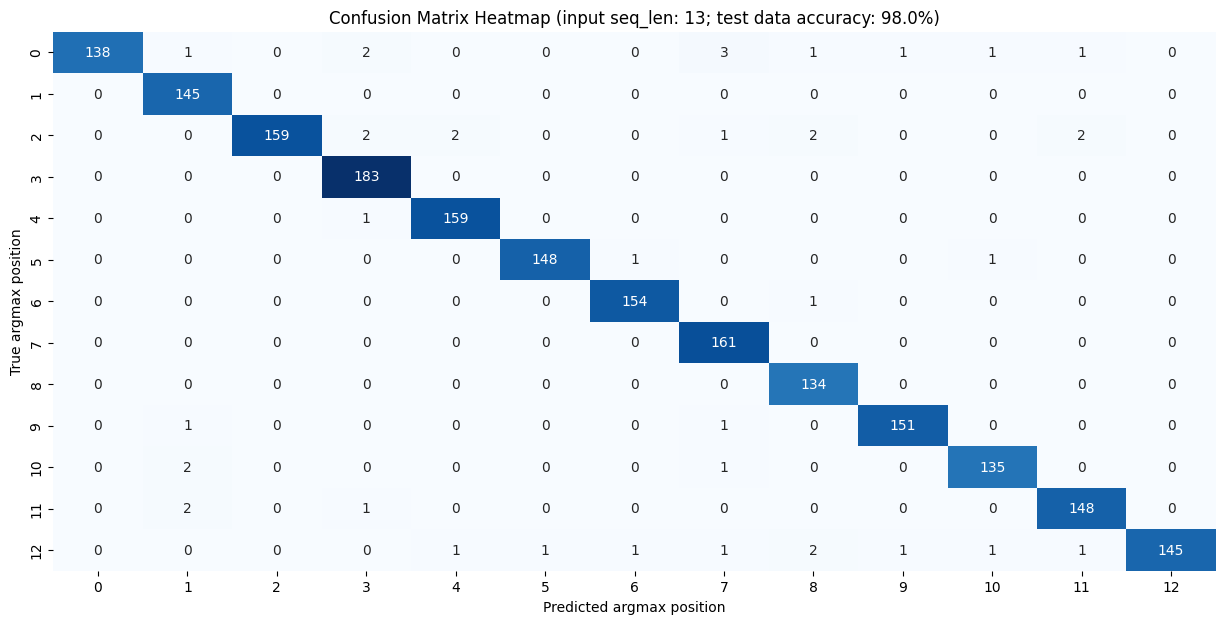

In [45]:
cm = confusion_matrix(test_true_outcome, test_predicted_outcome)

# Plot heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted argmax position")
plt.ylabel("True argmax position")
plt.title(f"Confusion Matrix Heatmap (input seq_len: {seq_len}; test data accuracy: {round(test_accuracy,2)}%)")
plt.show()